In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from datetime import datetime
import time 
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
import scipy.stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import optuna
#from xgboost import XGBRegressor
#from pycaret.regression import setup, compare_models, models
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p
from sklearn import linear_model
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [114]:
df_orders = pd.read_csv('data/Orders.csv',index_col=0)

In [115]:
df_returns = pd.read_csv('data/Returns.csv',index_col=0)

In [116]:
df_orders.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority
Row.ID,,,,,,,,,,,,,,,,,,,,,,,
40098,CA-2014-AB10015140-41954,11/11/14,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,$221.98,2,0.0,$62.15,40.77,High
26341,IN-2014-JR162107-41675,2/5/14,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black","$3,709.40",9,0.1,-$288.77,923.63,Critical
25330,IN-2014-CR127307-41929,10/17/14,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID","$5,175.17",9,0.1,$919.97,915.49,Medium
13524,ES-2014-KM1637548-41667,1/28/14,1/30/14,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless","$2,892.51",5,0.1,-$96.54,910.16,Medium
47221,SG-2014-RH9495111-41948,11/5/14,11/6/14,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed","$2,832.96",8,0.0,$311.52,903.04,Critical


In [117]:
df_returns.head()

,Order ID,Region
Returned,,
Yes,CA-2012-SA20830140-41210,Central US
Yes,IN-2012-PB19210127-41259,Eastern Asia
Yes,CA-2012-SC20095140-41174,Central US
Yes,IN-2015-JH158207-42140,Oceania
Yes,IN-2014-LC168857-41747,Oceania


In [118]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51290 entries, 40098 to 6147
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order.ID        51290 non-null  object 
 1   Order.Date      51290 non-null  object 
 2   Ship.Date       51290 non-null  object 
 3   Ship.Mode       51290 non-null  object 
 4   Customer.ID     51290 non-null  object 
 5   Customer.Name   51290 non-null  object 
 6   Segment         51290 non-null  object 
 7   Postal.Code     9994 non-null   float64
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Region          51290 non-null  object 
 12  Market          51290 non-null  object 
 13  Product.ID      51290 non-null  object 
 14  Category        51290 non-null  object 
 15  Sub.Category    51290 non-null  object 
 16  Product.Name    51290 non-null  object 
 17  Sales           51290 non-nu

In [119]:
df_orders.columns

Index(['Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode', 'Customer.ID',
       'Customer.Name', 'Segment', 'Postal.Code', 'City', 'State', 'Country',
       'Region', 'Market', 'Product.ID', 'Category', 'Sub.Category',
       'Product.Name', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Shipping.Cost', 'Order.Priority'],
      dtype='object')

In [120]:
df_orders['Profit'] = df_orders['Profit'].str.replace('$', '')

<ipython-input-120-2c5c2ad100b1>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_orders['Profit'] = df_orders['Profit'].str.replace('$', '')


In [121]:
df_orders['Profit'] = df_orders['Profit'].str.replace(',', '')

In [122]:
df_orders.Profit=df_orders.Profit.astype('float64')

In [123]:
df_orders.Sales

Row.ID
40098      $221.98
26341    $3,709.40
25330    $5,175.17
13524    $2,892.51
47221    $2,832.96
           ...    
29002       $65.10
34337       $16.72
31315        $8.56
9596        $13.44
6147        $61.38
Name: Sales, Length: 51290, dtype: object

In [124]:
df_orders['Sales'] = df_orders['Sales'].str.replace('$', '')
df_orders['Sales'] = df_orders['Sales'].str.replace(',', '')
df_orders.Sales=df_orders.Sales.astype('float64')

<ipython-input-124-f31c380abf8f>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_orders['Sales'] = df_orders['Sales'].str.replace('$', '')


In [125]:
df_orders.Sales

Row.ID
40098     221.98
26341    3709.40
25330    5175.17
13524    2892.51
47221    2832.96
          ...   
29002      65.10
34337      16.72
31315       8.56
9596       13.44
6147       61.38
Name: Sales, Length: 51290, dtype: float64

In [126]:
df_orders.Profit

Row.ID
40098     62.15
26341   -288.77
25330    919.97
13524    -96.54
47221    311.52
          ...  
29002      4.50
34337      3.34
31315      2.48
9596       2.40
6147       1.80
Name: Profit, Length: 51290, dtype: float64

# Problem 2: Inventory Management

In [127]:
df_orders["Order.Date"]=pd.to_datetime(df_orders["Order.Date"])

In [128]:
df_orders["Ship.Date"]=pd.to_datetime(df_orders["Ship.Date"])

In [129]:
df_orders["Ouarters"] = pd.PeriodIndex(df_orders["Order.Date"], freq='Q')

In [130]:
df_orders.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters
Row.ID,,,,,,,,,,,,,,,,,,,,,,,,
40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,2014Q4
26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,2014Q1
25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,2014Q4
13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,2014Q1
47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,2014Q4


In [131]:
df_orders.Ouarters.apply(lambda x: str(x)[-1])

Row.ID
40098    4
26341    1
25330    4
13524    1
47221    4
        ..
29002    2
34337    2
31315    3
9596     1
6147     2
Name: Ouarters, Length: 51290, dtype: object

In [132]:
df_orders.Ouarters=df_orders.Ouarters.apply(lambda x: str(x)[-1])

In [133]:
df_orders.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters
Row.ID,,,,,,,,,,,,,,,,,,,,,,,,
40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,4
26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,1
25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,4
13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,1
47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,4


In [134]:
df_orders.groupby("Ouarters").Quantity.sum()
#Quantity vs order.date

Ouarters
1    26691
2    41671
3    49121
4    60829
Name: Quantity, dtype: int64

Is there any seasonal trend of inventory in the company?
Q4 highest, Q1 lowest

Is the seasonal trend the same for different categories?
Q4 highest, Q1 lowest

In [135]:
df_orders.Category.value_counts()

Office Supplies    31289
Technology         10141
Furniture           9860
Name: Category, dtype: int64

In [136]:
df_orders.groupby(["Category","Ouarters"]).Quantity.sum()

Category         Ouarters
Furniture        1            5342
                 2            7923
                 3            9327
                 4           12300
Office Supplies  1           16103
                 2           25573
                 3           30209
                 4           36359
Technology       1            5246
                 2            8175
                 3            9585
                 4           12170
Name: Quantity, dtype: int64

In [137]:
df_orders.groupby(["Category","Ouarters"]).Quantity.describe()

count      mean       std  min  25%  50%  75%  \
Category        Ouarters                                                    
Furniture       1          1489.0  3.587643  2.343318  1.0  2.0  3.0  5.0   
                2          2279.0  3.476525  2.188895  1.0  2.0  3.0  5.0   
                3          2668.0  3.495877  2.272655  1.0  2.0  3.0  5.0   
                4          3424.0  3.592290  2.263198  1.0  2.0  3.0  5.0   
Office Supplies 1          4778.0  3.370239  2.264120  1.0  2.0  3.0  4.0   
                2          7469.0  3.423885  2.296978  1.0  2.0  3.0  5.0   
                3          8780.0  3.440661  2.262933  1.0  2.0  3.0  5.0   
                4         10262.0  3.543072  2.311913  1.0  2.0  3.0  5.0   
Technology      1          1560.0  3.362821  2.248604  1.0  2.0  3.0  4.0   
                2          2373.0  3.445006  2.254850  1.0  2.0  3.0  4.0   
                3          2770.0  3.460289  2.250808  1.0  2.0  3.0  5.0   
                4          3438.0  3.539849  2.291275  1.0  2.0  3.0  5.0   

                           max  
Category        Ouarters        
Furniture       1         14.0  
                2         14.0  
                3         14.0  
                4         14.0  
Office Supplies 1         14.0  
                2         14.0  
                3         14.0  
                4         14.0  
Technology      1         14.0  
                2         14.0  
                3         14.0  
                4         14.0

# Problem 3: Why did customers make returns?

In [159]:
df_returns['Order.ID'] = df_returns['Order ID']
df_returns.drop(columns='Order ID', inplace=True)
df_total = pd.merge(df_orders, df_returns, on=['Order.ID','Region'])

KeyError: 'Order ID'

In [160]:
df_total = pd.merge(df_orders, df_returns, on=['Order.ID','Region'])

In [162]:
df_total['Year'] = pd.DatetimeIndex(df_total['Order.Date']).year

In [163]:
df_total.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,Returned,Year
0,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-TA-5060,Furniture,Tables,"Lesro Conference Table, with Bottom Storage",1715.16,2,0.0,720.36,725.57,Critical,4,Yes,2012
1,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-BO-5762,Furniture,Bookcases,"Safco Classic Bookcase, Pine",2197.50,5,0.0,153.75,627.27,Critical,4,Yes,2012
2,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-TA-5065,Furniture,Tables,"Lesro Round Table, with Bottom Storage",1356.03,3,0.0,311.85,458.97,Critical,4,Yes,2012
3,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-CH-5454,Furniture,Chairs,"Office Star Swivel Stool, Adjustable",882.15,5,0.0,114.60,203.92,Critical,4,Yes,2012
4,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,TEC-MA-5494,Technology,Machines,"Okidata Calculator, Red",148.32,3,0.0,68.22,25.48,Critical,4,Yes,2012


In [164]:
df_returns=df_returns.reset_index()

In [165]:
#Q3.1
df_total.groupby(['Year','Returned']).agg({'Profit': 'sum'})

,,Profit
Year,Returned,
2012,Yes,17396.86
2013,Yes,9077.77
2014,Yes,17180.12
2015,Yes,17114.50


In [227]:
df_yearly_profit=df_total.groupby(['Year','Returned']).agg({'Profit': 'sum'})

In [228]:
df_yearly_profit=df_yearly_profit.reset_index()

<AxesSubplot:xlabel='Year'>

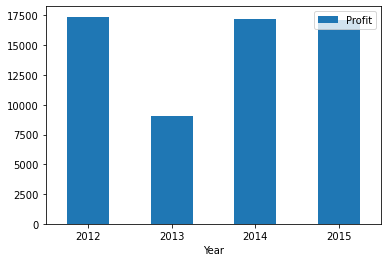

In [229]:
df_yearly_profit.plot.bar(x='Year', y='Profit', rot=0)

In [181]:
df_total.groupby("Customer.ID").Returned.count()>1

Customer.ID
AA-1031558      False
AA-106451404    False
AA-1064559       True
AA-1064564      False
AA-645137       False
                ...  
WB-218501406     True
WB-2185064      False
YS-2188093      False
ZC-219101402    False
ZD-2192548      False
Name: Returned, Length: 1053, dtype: bool

In [264]:
#3.2 #How many customer returned more than once?
(df_total.groupby("Customer.ID").Returned.count()>1).sum()

543

In [185]:
#3.2.2 #How many customer returned more than 5 times?
(df_total.groupby("Customer.ID").Returned.count()>5).sum()

46

In [268]:
df_frequent_returners = pd.DataFrame({'Once': [543], '5Times': [46]})

In [288]:
df_frequent_returners=pd.DataFrame.transpose(df_frequent_returners)

In [289]:
df_frequent_returners

,0
Once,543
5Times,46


<AxesSubplot:>

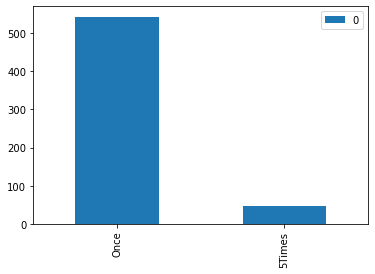

In [290]:
df_frequent_returners.plot.bar()
#plt.xticks(ticks = [1,2], labels = ["Once","5Times"])
#plt.xticks(pop_rank,top10.country,rotation='vertical')

In [291]:
#3.3 Which regions are more likely to return orders?
df_plot_region=df_total.groupby("Region").Returned.count().sort_values(ascending=False)
df_plot_region

Region
Central America      248
Western Europe       233
Western US           177
Oceania              154
Southeastern Asia    140
Eastern US           134
South America        133
Eastern Asia         131
Southern Europe      112
Southern Asia        111
Western Asia         108
Southern US           83
Northern Europe       76
Central US            71
Caribbean             69
Western Africa        60
North Africa          51
Eastern Europe        42
Southern Africa       25
Eastern Africa        18
Central Africa        17
Central Asia           9
Name: Returned, dtype: int64

<AxesSubplot:xlabel='Region'>

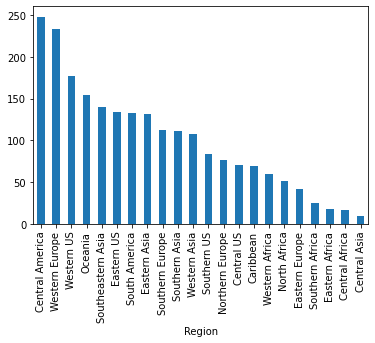

In [296]:
df_plot_region.plot.bar()

In [297]:
#3.4
df_category=df_total.groupby(["Category","Sub.Category"]).Returned.count().sort_values(ascending=False)
df_category

Category         Sub.Category
Office Supplies  Binders         263
                 Art             216
                 Storage         208
                 Paper           150
Furniture        Chairs          147
Technology       Phones          145
                 Accessories     137
Office Supplies  Labels          135
Furniture        Furnishings     135
                 Bookcases       103
Office Supplies  Supplies        102
                 Fasteners       102
                 Envelopes        99
Technology       Copiers          98
                 Machines         62
Office Supplies  Appliances       59
Furniture        Tables           41
Name: Returned, dtype: int64

<AxesSubplot:ylabel='Category,Sub.Category'>

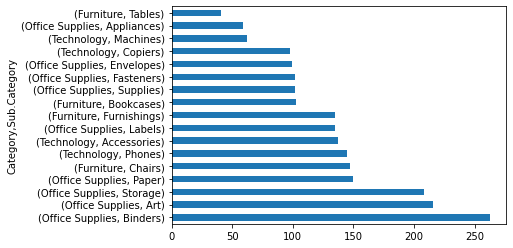

In [304]:
df_category.plot.barh()

In [193]:
pd.DataFrame(df_total.groupby(["Category","Sub.Category"]).Returned.count().sort_values(ascending=False))

Returned
Category        Sub.Category          
Office Supplies Binders            263
                Art                216
                Storage            208
                Paper              150
Furniture       Chairs             147
Technology      Phones             145
                Accessories        137
Office Supplies Labels             135
Furniture       Furnishings        135
                Bookcases          103
Office Supplies Supplies           102
                Fasteners          102
                Envelopes           99
Technology      Copiers             98
                Machines            62
Office Supplies Appliances          59
Furniture       Tables              41

# Part II

## Problem 4: Feature Engineering

In [306]:
df_total.head()

,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,State,Country,Region,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Ouarters,Returned,Year
0,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-TA-5060,Furniture,Tables,"Lesro Conference Table, with Bottom Storage",1715.16,2,0.0,720.36,725.57,Critical,4,Yes,2012
1,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-BO-5762,Furniture,Bookcases,"Safco Classic Bookcase, Pine",2197.50,5,0.0,153.75,627.27,Critical,4,Yes,2012
2,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-TA-5065,Furniture,Tables,"Lesro Round Table, with Bottom Storage",1356.03,3,0.0,311.85,458.97,Critical,4,Yes,2012
3,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,FUR-CH-5454,Furniture,Chairs,"Office Star Swivel Stool, Adjustable",882.15,5,0.0,114.60,203.92,Critical,4,Yes,2012
4,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,Taipei City,Taiwan,Eastern Asia,Asia Pacific,TEC-MA-5494,Technology,Machines,"Okidata Calculator, Red",148.32,3,0.0,68.22,25.48,Critical,4,Yes,2012


In [308]:
df_total.columns

Index(['Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode', 'Customer.ID',
       'Customer.Name', 'Segment', 'Postal.Code', 'City', 'State', 'Country',
       'Region', 'Market', 'Product.ID', 'Category', 'Sub.Category',
       'Product.Name', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Shipping.Cost', 'Order.Priority', 'Ouarters', 'Returned', 'Year'],
      dtype='object')

In [309]:
df_total.Returned.unique()

array(['Yes'], dtype=object)

In [311]:
pd.merge(df_orders, df_returns, on=['Order.ID'])

NameError: name 'left' is not defined

In [ ]:
pd.merge(df_orders,df_returns,left)